In [1]:
import os
import glob
import numpy as np
import pandas as pd
import clima_anom as ca
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from descartes import PolygonPatch

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, Point
import rtree as rt

import cartopy.io.shapereader as shpreader

In [2]:
# so = 'manjaro'
so = 'xubuntu'

In [3]:
if so == 'xubuntu':
    base = '/media/'
elif so == 'manjaro':
    base = '/run/media/'
print(f'so  : {so}')
print(f'base: {base}')

so  : xubuntu
base: /media/


In [4]:
file_shape = '../mappings/SaoPaulo_Fixed.shp'
sp = list(shpreader.Reader(file_shape).geometries())

In [5]:
Ano = '2018'
Mes = '03'

In [18]:
lat_c = -22.8611
lon_c = -47.0563

resolution = 8/111
r = (180)/111

In [19]:
lon_s = lon_c - 22.5*resolution
lon_e = lon_s + 45*resolution
print(f'lon start: {lon_s}')
print(f'lon end  : {lon_e}')
print()
lat_s = lat_c - 22.5*resolution
lat_e = lat_s + 45*resolution
print(f'lat start: {lat_s}')
print(f'lat end  : {lat_e}')

lon start: -48.67792162162162
lon end  : -45.43467837837838

lat start: -24.48272162162162
lat end  : -21.23947837837838


In [20]:
lon_ref = np.arange(lon_s,lon_e,resolution)
lat_ref = np.arange(lat_s,lat_e,resolution)
print(f'lon len: {len(lon_ref)}')
print(f'lat len: {len(lat_ref)}')

lon len: 45
lat len: 45


In [21]:
# Grilla Sao Paulo
lons = np.linspace(lon_s,lon_e,46)
lats = np.linspace(lat_s,lat_e,46)
print(f'lon grid len: {len(lons)}')
print(f'lat grid len: {len(lats)}')

lon grid len: 46
lat grid len: 46


In [22]:
grids = list()
for lat in range(lats.size-1):
    for lon in range(lons.size-1):
        lu = Point(lons[lon], lats[lat])
        ru = Point(lons[lon+1], lats[lat])
        rb = Point(lons[lon+1], lats[lat+1])
        lb = Point(lons[lon], lats[lat+1])
        poly = Polygon((lu, ru, rb, lb, lu))
        grids.append(poly)

grid = np.reshape(grids, (lats.size-1, lons.size-1))

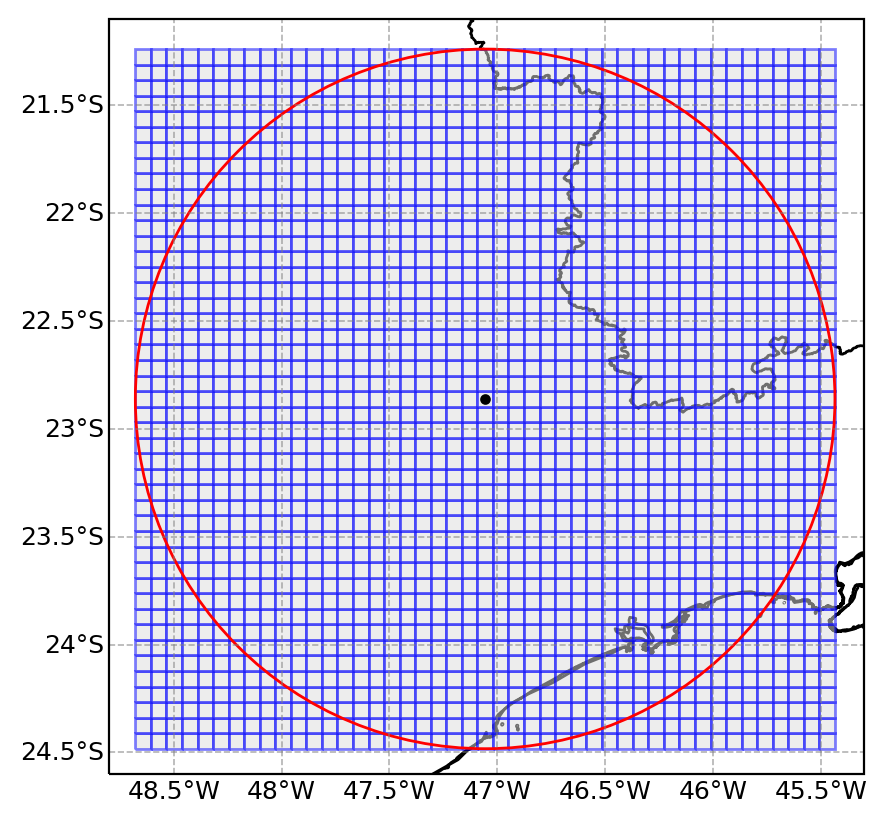

In [23]:
circle = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

fig = plt.figure(figsize=(5,5),dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-48.8,-45.3,-24.6,-21.1])
ax.add_geometries(sp,ccrs.PlateCarree(),edgecolor='k',facecolor='None',linestyle='-',linewidth=1)

for g in grids:
    patch = PolygonPatch(g, fc='#dcdcdc', ec='b', zorder=1, alpha=0.5)
    ax.add_patch(patch)

ax.scatter(lon_c,lat_c, s=8, color='black', zorder=3)
ax.add_artist(circle)

gl = ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 9, 'color': 'black'}
gl.ylabel_style = {'size': 9, 'color': 'black'}

# salida = '../images/BrasilDat_grid_region.png'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [24]:
list_dir = base + 'arturo/Arturo/Data/GLM/Campinas/2018/point_5min/*.csv'
list_file = glob.glob(list_dir)
lista = sorted(list_file)
print(f'Files number: {len(lista)}')

Files number: 8928


In [25]:
# #Use list of BrasilDat incomplete data
# list_file_BrasilDat = glob.glob(base + 'arturo/Arturo/Data/BrasilDat/Campinas/2018/point/*.csv')
# lista_BrasilDat = sorted(list_file_BrasilDat)
# tempos_BrasilDat = len(lista_BrasilDat)
# print()
# print(f'Files number: {tempos_BrasilDat}')

In [28]:
list_tempos = pd.read_csv(base + 'arturo/Arturo/Data/GLM/Campinas/list/list_BrasilDat_intersection/list_BrasilDat_datas_5min.csv')
tempos = len(list_tempos)
print(list_tempos.head(4))
print()
print(f'Files number: {tempos}')

                   data
0  2018_03_01_00_00.csv
1  2018_03_01_00_05.csv
2  2018_03_01_00_10.csv
3  2018_03_01_00_15.csv

Files number: 8928


In [29]:
Densidad = np.zeros([tempos,len(lat_ref),len(lon_ref)])
count = 0

for i in range(tempos): 
    
    file_dir = base + 'arturo/Arturo/Data/BrasilDat/Campinas/2018/point/' + list_tempos['data'][i]
    filename = file_dir.split('/')[9]
    ano = filename.split('_')[0]
    mes = filename.split('_')[1]
    dia = filename.split('_')[2]
    hora = filename.split('_')[3]
    minu =filename.split('_')[4][0:-4]

    if os.path.exists(file_dir):

        # if i % 500 == 0 or i == tempos:
        #     print(i,'de',tempos)

        file_dir2 = base + 'arturo/Arturo/Data/GLM/Campinas/2018/point_5min/' + list_tempos['data'][i]
        data_in = pd.read_csv(file_dir2)

        data = pd.DataFrame({'Lat':data_in['Lat'],'Lon':data_in['Lon']})

        tree = rt.index.Index()

        for i, row in data.iloc[:,:].iterrows():
            tree.insert(i, Point(row.Lon, row.Lat).bounds)

        mapping = list()

        for g in grids:
            matches = list(tree.intersection(g.bounds))
            mapping.append(len(matches))

        density = np.reshape(mapping, (lats.size-1, lons.size-1))

    
    else:
        print(f'   {dia} {hora}:{minu} Don\'t Exists')
        density = np.ones([len(lat_ref),len(lon_ref)])*np.nan

    Densidad[count,:,:] = density
    count = count + 1

   01 06:00 Don't Exists
   01 06:05 Don't Exists
   01 06:10 Don't Exists
   01 06:15 Don't Exists
   01 06:20 Don't Exists
   01 06:25 Don't Exists
   01 06:30 Don't Exists
   01 06:35 Don't Exists
   01 06:40 Don't Exists
   01 06:45 Don't Exists
   01 06:50 Don't Exists
   01 06:55 Don't Exists
   01 07:00 Don't Exists
   01 07:05 Don't Exists
   01 07:10 Don't Exists
   01 07:15 Don't Exists
   01 07:20 Don't Exists
   01 07:25 Don't Exists
   01 07:30 Don't Exists
   01 07:35 Don't Exists
   01 07:40 Don't Exists
   01 07:45 Don't Exists
   01 07:50 Don't Exists
   01 07:55 Don't Exists
   01 08:00 Don't Exists
   01 08:05 Don't Exists
   01 08:10 Don't Exists
   01 08:15 Don't Exists
   01 08:20 Don't Exists
   01 08:25 Don't Exists
   01 08:30 Don't Exists
   01 08:35 Don't Exists
   01 08:40 Don't Exists
   01 08:45 Don't Exists
   01 08:50 Don't Exists
   01 08:55 Don't Exists
   01 09:00 Don't Exists
   01 09:05 Don't Exists
   01 09:10 Don't Exists
   01 09:15 Don't Exists


In [30]:
lon2d, lat2d = np.meshgrid(lon_ref,lat_ref)
flash_mean = np.nanmean(Densidad,axis=0)

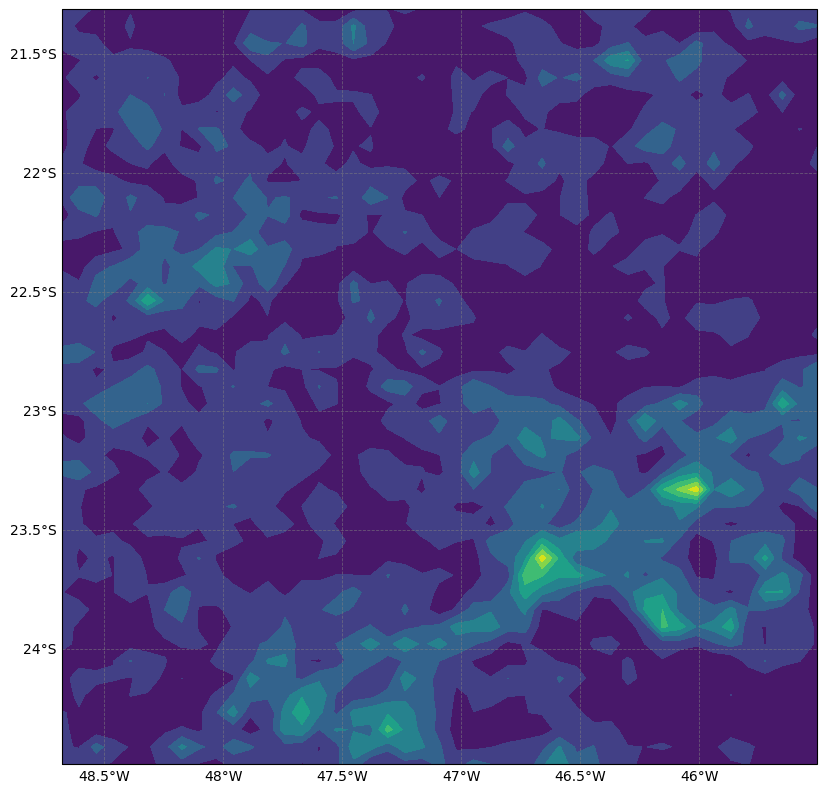

In [31]:
fig = plt.figure(figsize=(10,10),dpi=100)
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines()

ax.contourf(lon2d,lat2d,flash_mean)

gl = ax.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False

In [32]:
print(np.shape(Densidad))
info = {'file': base + 'arturo/Arturo/Data/GLM/Campinas/2018/grid/GLM_2018_03_5min_8kmx8km.nc',
        'title': 'GLM data 14km x 14km', 
        'year_start':2019,'month_start':3,'day_start':1,'hour_start':0,'minute_start':0,
        'year_end':2019,'month_end':3,'day_end':31,'hour_end':23,'minute_end':55,
        'time_frequency': 'Minutely', 
        'time_interval': 5,
        'var_name': 'flash', 
        'var_units': 'flash/196km2'} 

(8928, 45, 45)


In [33]:
ca.create_netcdf(info,Densidad,lat_ref,lon_ref)

Time Start: 2019-03-01 00:00:00
Time End: 2019-03-31 23:55:00
Time Frequency: Minutely
Time Lenght: 8928

File created in:  /media/arturo/Arturo/Data/GLM/Campinas/2018/grid/GLM_2018_03_5min_8kmx8km.nc
File title:  GLM data 14km x 14km
var title:  flash
var units:  flash/196km2
